In [9]:
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('seaborn')

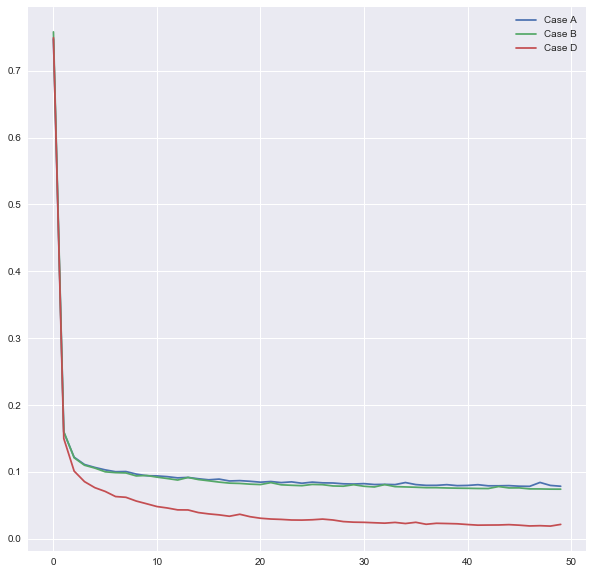

In [35]:
# plot the convergence
a_convergence = np.load('a_convergence_curve.npy')
b_convergence = np.load('b_convergence_curve.npy')
# c_convergence = np.load('c_convergence_curve.npy')
d_convergence = np.load('d_convergence_curve.npy')

plt.figure(figsize=(10,10))
plt.plot(a_convergence,label='Case A')
plt.plot(b_convergence,label='Case B')
# plt.plot(c_convergence),label='Case C')
plt.plot(d_convergence,label='Case D')
plt.legend()
plt.show()

In [34]:
# # plot the MI
# a_mi = np.load('a_MI.npy')
# b_mi = np.load('b_MI.npy')
# # a_mi = np.load('c_convergence_curve.npy')
# d_mi = np.load('d_MI.npy')

# plt.figure(figsize=(10,10))
# plt.plot(a_mi[:,0],label="Upper")

# plt.plot(a_mi[:,4],label="Case a",color='red'); plt.fill_between(range(5000),a_mi[:,2],a_mi[:,3], color='red', alpha='0.5')
# plt.plot(b_mi[:,4],label="Case a",color='green'); plt.fill_between(range(5000),b_mi[:,2],b_mi[:,3], color='green', alpha='0.5')



# plt.legend()
# plt.show()

(5000, 96, 96, 3) 1.0 0.0
(5000, 10) 1.0 0.0
(8000, 96, 96, 3) 1.0 0.0
(8000, 10) 1.0 0.0


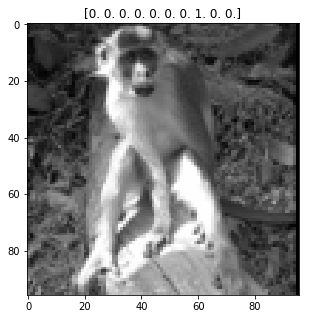

In [2]:
# read the data
train_images,train_labels,test_images,test_labels = read_STL10_data()
train_images = train_images.mean(3,keepdims=True)
train_images = (train_images-train_images.min((0,1,2),keepdims=True))/(train_images.max((0,1,2),keepdims=True)-train_images.min((0,1,2),keepdims=True)+1e-8)
rand_choice  = np.random.choice(len(train_images))
plt.figure(figsize=(5,5))
plt.imshow(np.squeeze(train_images[rand_choice]),cmap='gray'); plt.title(str(train_labels[rand_choice])); plt.show()

In [3]:
# import torch
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch import nn as nn

from torchvision.transforms import ToTensor
from torch.optim import Adam
from tqdm import tqdm
from pathlib import Path
import statistics as stats

from scipy.stats import chi2_contingency
from sklearn.metrics import mutual_info_score
from skimage.filters import roberts, sobel, scharr, prewitt
from skimage import feature

class Encoder(nn.Module):
    def __init__(self):
        super().__init__()
        self.c0 = nn.ConvTranspose2d(1, 32,  kernel_size=3, stride=1,padding=0)
        self.c1 = nn.ConvTranspose2d(32, 32, kernel_size=3, stride=1,padding=0)
        self.c2 = nn.Conv2d(32, 32, kernel_size=3, stride=1,padding=0)
        self.c3 = nn.Conv2d(32, 32, kernel_size=3, stride=1,padding=0)

        self.b1 = nn.BatchNorm2d(32)
        self.b2 = nn.BatchNorm2d(32)
        self.b3 = nn.BatchNorm2d(32)

    def forward(self, x):
        h = F.relu(self.c0(x))
        h = F.relu(self.b1(self.c1(h)))
        h = F.relu(self.b2(self.c2(h)))
        h = F.relu(self.b3(self.c3(h)))
        return h
class LocalDiscriminator(nn.Module):
    def __init__(self):
        super().__init__()
        self.c0 = nn.Conv2d(33, 64, kernel_size=1)
        self.c1 = nn.Conv2d(64, 64, kernel_size=1)
        self.c2 = nn.Conv2d(64, 1, kernel_size=1)

    def forward(self, x):
        h = F.relu(self.c0(x))
        h = F.relu(self.c1(h))
        return self.c2(h)
class GlobalDiscriminator(nn.Module):
    def __init__(self):
        super().__init__()
        self.c0 = nn.Conv2d(33, 64, kernel_size=3)
        self.c1 = nn.Conv2d(64, 64, kernel_size=3)
        self.l0 = nn.Linear(64 * 92 * 92, 256)
        self.l1 = nn.Linear(256, 256)
        self.l2 = nn.Linear(256, 1)

    def forward(self, M):
        h = F.relu(self.c0(M))
        h = self.c1(h)
        h = h.view(h.shape[0], -1)
        h = F.relu(self.l0(h))
        h = F.relu(self.l1(h))
        return self.l2(h)
class PriorDiscriminator(nn.Module):
    def __init__(self):
        super().__init__()
        self.l0 = nn.Conv2d(32, 64, kernel_size=1)
        self.l1 = nn.Conv2d(64, 64, kernel_size=1)
        self.l2 = nn.Conv2d(64, 1, kernel_size=1)

    def forward(self, x):
        h = F.relu(self.l0(x))
        h = F.relu(self.l1(h))
        return torch.sigmoid(self.l2(h))
class DeepInfoMaxLoss(nn.Module):
    def __init__(self, alpha=0.1, beta=0.1, gamma=0.8):
        super().__init__()
        self.global_d = GlobalDiscriminator()
        self.local_d  = LocalDiscriminator()
        self.prior_d  = PriorDiscriminator()
        self.alpha = alpha
        self.beta  = beta
        self.gamma = gamma

    def forward(self, image,M, M_prime):

        # see appendix 1A of https://arxiv.org/pdf/1808.06670.pdf
        y_M       = torch.cat((M, image), dim=1)
        y_M_prime = torch.cat((M_prime, image), dim=1)

        Ej = -F.softplus(-self.local_d(y_M)).mean()
        Em = F.softplus(self.local_d(y_M_prime)).mean()
        LOCAL = (Em - Ej) * self.beta

        Ej = -F.softplus(-self.global_d(y_M)).mean()
        Em = F.softplus(self.global_d(y_M_prime)).mean()
        GLOBAL = (Em - Ej) * self.alpha
        
        prior = torch.rand_like(M)

        term_a = torch.log(self.prior_d(prior)).mean()
        term_b = torch.log(1.0 - self.prior_d(M)).mean()
        PRIOR = - (term_a + term_b) * self.gamma

        return LOCAL + GLOBAL + PRIOR
    
def calc_MI1(x, y, bins=30):
    c_xy = np.histogram2d(x, y, bins)[0]
    g, p, dof, expected = chi2_contingency(c_xy, lambda_="log-likelihood")
    mi = 0.5 * g / c_xy.sum()
    return mi
def calc_MI2(x, y, bins=30):
    c_xy = np.histogram2d(x, y, bins)[0]
    mi   = mutual_info_score(None, None, contingency=c_xy)
    return mi

In [4]:
# set up 
device     = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
encoder    = Encoder().to(device)
loss_fn    = DeepInfoMaxLoss().to(device)
optim      = Adam(encoder.parameters(), lr=1e-4)
loss_optim = Adam(loss_fn.parameters(), lr=1e-4)

In [5]:
# train
num_epoch  = 50
batch_size = 10
convergence_values = []
running_loss = 0
for iter in range(num_epoch):
    train_images = shuffle(train_images)
    for current_batch_index in range(0,len(train_images),batch_size):
        current_batch  = train_images[current_batch_index:current_batch_index+batch_size,:,:,:]
        current_batch  = np.transpose(current_batch,(0,3,1,2)).astype(np.float32)
        current_batch_s= np.array([resize(np.squeeze(x),(88,88)) for x in current_batch]).astype(np.float32)[:,None,:,:]
        x         = torch.from_numpy(current_batch).to(device)
        optim.zero_grad()
        loss_optim.zero_grad()
        M       = encoder(x)
        M_prime = torch.cat((M[1:], M[0].unsqueeze(0)), dim=0)
        loss    = loss_fn(x, M, M_prime)
        sys.stdout.write('Current Iter: '+str(iter)+'/'+str(num_epoch)+" Batch: "+str(current_batch_index)+'/'+str(len(train_images))+' loss : ' + str(loss.item()) + '\r')
        sys.stdout.flush(); 
        loss.backward(); optim.step(); loss_optim.step()
        running_loss = running_loss + loss.item()
    convergence_values.append(running_loss/(len(train_images)/batch_size))
    if iter % 1 == 0 : print('\n Current Iter :',iter," Current loss: ",convergence_values[-1])
    running_loss = 0

Current Iter: 0/50 Batch: 4990/5000 loss : 0.21049815416336065
 Current Iter : 0  Current loss:  0.7491882089674473
Current Iter: 1/50 Batch: 4990/5000 loss : 0.10850428789854055
 Current Iter : 1  Current loss:  0.14993008668720723
Current Iter: 2/50 Batch: 4990/5000 loss : 0.09293190389871597
 Current Iter : 2  Current loss:  0.10126765123009682
Current Iter: 3/50 Batch: 4990/5000 loss : 0.07883121818304062
 Current Iter : 3  Current loss:  0.08550322583317757
Current Iter: 4/50 Batch: 4990/5000 loss : 0.065826304256916056
 Current Iter : 4  Current loss:  0.07648604442179203
Current Iter: 5/50 Batch: 4990/5000 loss : 0.102066330611705785
 Current Iter : 5  Current loss:  0.07087123622000217
Current Iter: 6/50 Batch: 4990/5000 loss : 0.059451196342706685
 Current Iter : 6  Current loss:  0.06320602079480886
Current Iter: 7/50 Batch: 4990/5000 loss : 0.063306458294391636
 Current Iter : 7  Current loss:  0.06209681975096464
Current Iter: 8/50 Batch: 4990/5000 loss : 0.0445523634552955

(5000, 96, 96, 3) 1.0 0.0
(5000, 10) 1.0 0.0
(8000, 96, 96, 3) 1.0 0.0
(8000, 10) 1.0 0.0


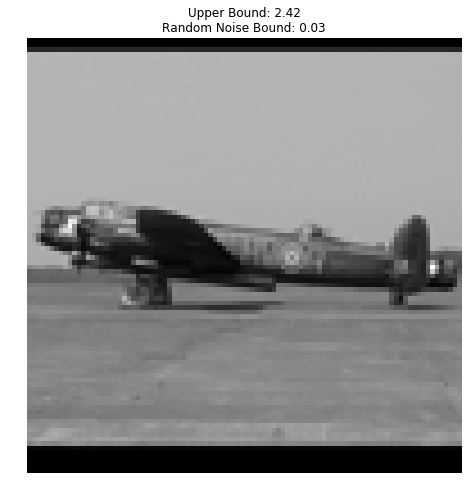

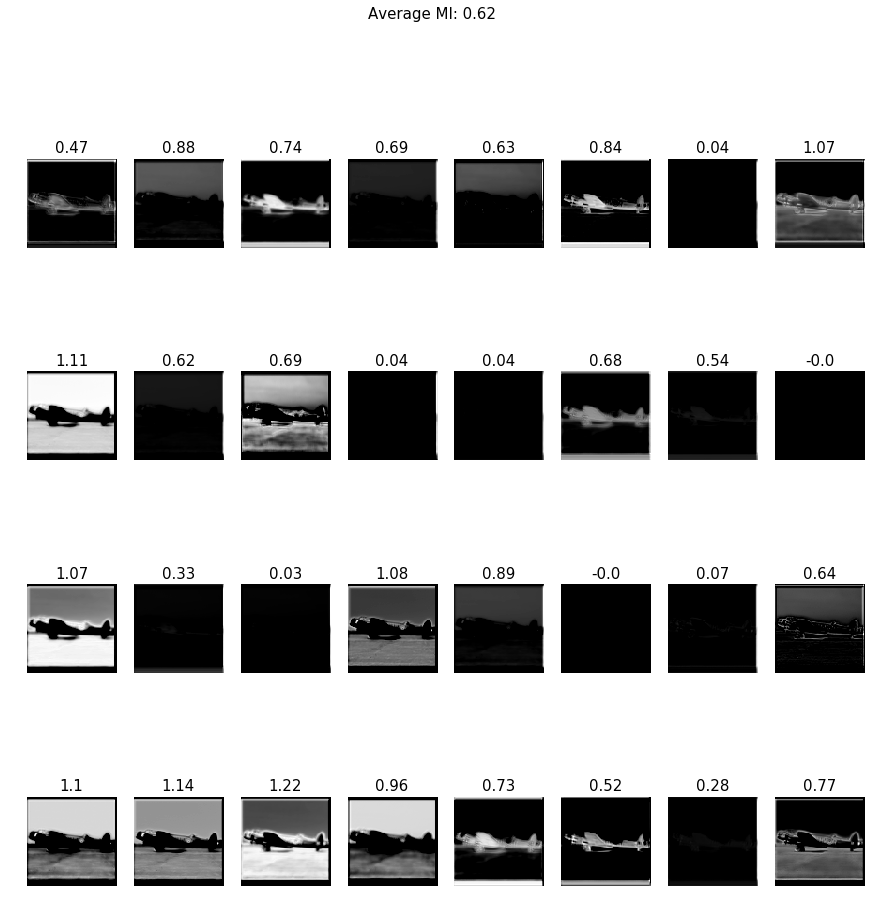

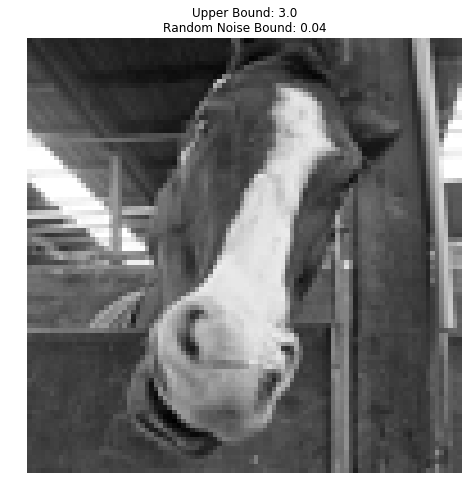

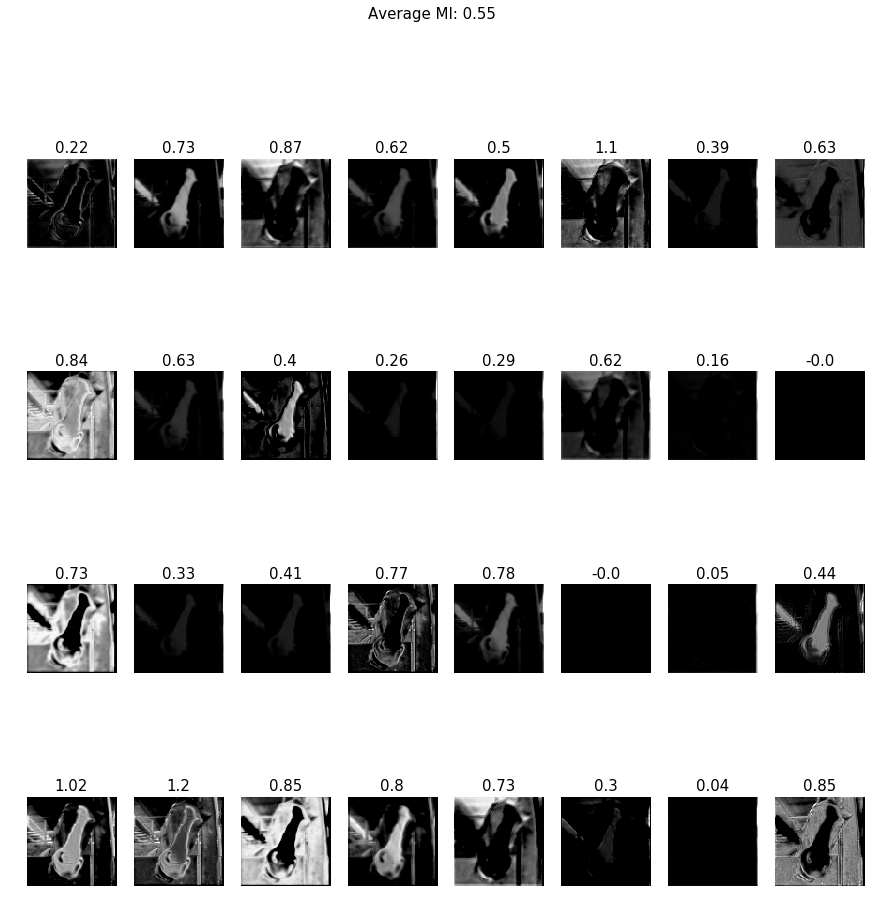

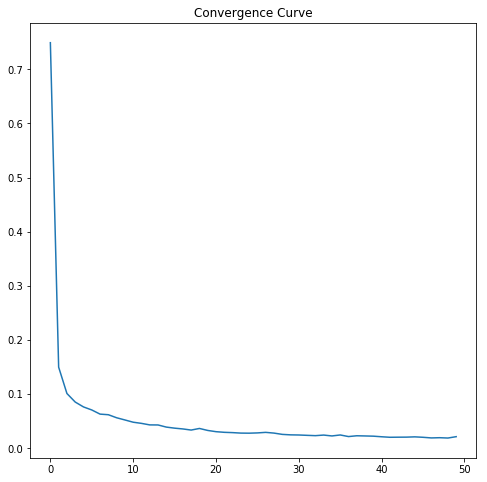

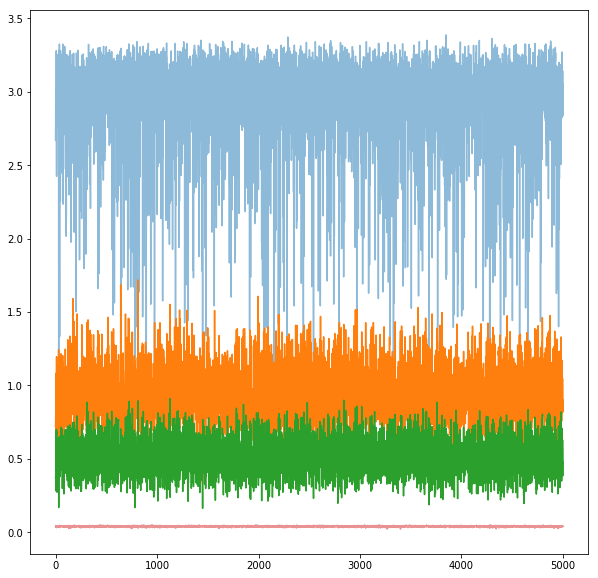

In [6]:
# re-read the images
train_images,train_labels,test_images,test_labels = read_STL10_data()
train_images = train_images.mean(3,keepdims=True)
train_images = (train_images-train_images.min((0,1,2),keepdims=True))/(train_images.max((0,1,2),keepdims=True)-train_images.min((0,1,2),keepdims=True)+1e-8)

# plot two images and show convergence curve
def plot_image_and_feature(first_image_select):
    first_image_select_resize = np.squeeze(first_image_select)

    first_image = torch.from_numpy(np.transpose(first_image_select[None,:,:,:],(0,3,1,2)).astype(np.float32)).to(device)
    first_M = encoder(first_image)
    M_np = first_M.cpu().detach().numpy()
    M_np = np.transpose(M_np,(0,2,3,1))
    M_np = (M_np-M_np.min((0,1,2),keepdims=True))/(M_np.max((0,1,2),keepdims=True)-M_np.min((0,1,2),keepdims=True)+1e-8)

    plt.figure(figsize=(8,8))
    plt.imshow(np.squeeze(first_image_select),cmap='gray'); 
    plt.title("Upper Bound: "+
              str(np.around(calc_MI2(first_image_select.ravel(),first_image_select.ravel()),2)) +
              "\nRandom Noise Bound: " +
              str(np.around(calc_MI2(np.random.normal(size=first_image_select.shape).ravel(),first_image_select.ravel()),2))
             )
    plt.axis('off')
    plt.show()

    plt.figure(figsize=(15,15))
    image = 1; total_mi = 0
    for i in range(len(M_np.T)):
        plt.subplot(4,8,i+1)
        plt.imshow(M_np[0,:,:,i],cmap='gray'); 
        plt.title(str(np.around(calc_MI2(M_np[0,:,:,i].ravel(),first_image_select_resize.ravel()),2)),fontsize=15)
        plt.axis('off')
        total_mi = total_mi +calc_MI2(M_np[0,:,:,i].ravel(),first_image_select_resize.ravel())
    plt.suptitle("Average MI: "+str(np.around(total_mi/len(M_np.T),2) ),fontsize=15)
    plt.show()

# show two images
plot_image_and_feature(train_images[10])
plot_image_and_feature(train_images[11])

# show convergence curve / save
plt.figure(figsize=(8,8))
plt.plot(convergence_values)
plt.title("Convergence Curve")
plt.show()
np.save("c_convergence_curve.npy",convergence_values)

# for all of the images do MI 
all_image_mi = []
for index in range(len(train_images)):
    sys.stdout.write('Current index: '+str(index)+'/'+str(len(train_images))+'\r')
    sys.stdout.flush(); 
    temp_list = []
    current_image_resize = np.squeeze(train_images[index,:,:,:])
    current_image = torch.from_numpy(np.transpose(train_images[index,:,:,:][None,:,:,:],(0,3,1,2)).astype(np.float32)).to(device)
    current_M = encoder(current_image)
    M_np = current_M.cpu().detach().numpy()
    M_np = np.squeeze((M_np-M_np.min((0,1,2),keepdims=True))/(M_np.max((0,1,2),keepdims=True)-M_np.min((0,1,2),keepdims=True)+1e-8))
    
    for features in M_np: temp_list.append(calc_MI2(features.ravel(),current_image_resize.ravel()))
        
    upper_bound = calc_MI2(current_image_resize.ravel(),current_image_resize.ravel())
    noise_bound = calc_MI2(np.random.normal(size=current_image_resize.shape).ravel(),current_image_resize.ravel())
    all_image_mi.append(
        (upper_bound,noise_bound,max(temp_list),min(temp_list),np.mean(temp_list),np.std(temp_list))
    )
all_image_mi = np.asarray(all_image_mi)
np.save("c_MI.npy",all_image_mi)
plt.figure(figsize=(10,10))
plt.plot(all_image_mi[:,0],alpha=0.5)
plt.plot(all_image_mi[:,2])
plt.plot(all_image_mi[:,4])
plt.plot(all_image_mi[:,1],alpha=0.5)
plt.show()